### Notebook: Preparing Time Independent Models

31 May 2024

Objectives:
- Further work on cross-validation
- Analysis and visuals
- Deal with age issue


## 0. Setup

In [42]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, auc

# ------------------------------------------------
from catboost import CatBoostClassifier, Pool, cv #, MetricVisualizer
from catboost.utils import get_roc_curve

# ------------------------------------------------

data_path = "../../main_data/locale_specific_data/"

In [14]:
dog_df = pd.read_csv(data_path + "Sonoma_time_independent_data_akry.csv")

dog_df.head()

,breed,color,sex,size,date_of_birth,animal_id,intake_date,outcome_date,days_in_shelter,intake_type,...,outcome_adopt,outcome_adopt_subtype,intake_age,outcome_age,pop_control,sex_bin,size_bin,breed_pit,color_mix,intake_bin
0,PIT BULL,GRAY/WHITE,Female,MED,2012-09-03,A296009,2013-08-22,2014-04-14,235,TRANSFER,...,False,none,0.97,1.61,1,1,3,1,1,4
1,PIT BULL,BLUE/WHITE,Female,MED,2012-10-09,A294143,2013-08-31,2014-04-14,226,STRAY,...,False,none,0.89,1.51,1,1,3,1,1,0
2,CAROLINA DOG/MIX,GOLD/WHITE,Male,MED,2007-09-07,A281788,2013-09-19,2014-07-30,314,STRAY,...,False,none,6.03,6.90,0,0,3,0,1,0
3,CHIHUAHUA SH,TAN,Male,TOY,2007-10-01,A297574,2013-10-01,2014-01-01,92,OWNER SURRENDER,...,False,none,6.00,6.25,1,0,1,0,0,1
4,PIT BULL,TAN/WHITE,Male,MED,2012-10-29,A298002,2013-10-08,2014-05-22,226,STRAY,...,True,realtime,0.95,1.57,1,0,3,1,1,0


In [15]:
dog_df.columns

Index(['breed', 'color', 'sex', 'size', 'date_of_birth', 'animal_id',
       'intake_date', 'outcome_date', 'days_in_shelter', 'intake_type',
       'intake_subtype', 'outcome_type', 'outcome_subtype', 'intake_condition',
       'outcome_condition', 'dob_season', 'intake_season', 'outcome_season',
       'outcome_adopt', 'outcome_adopt_subtype', 'intake_age', 'outcome_age',
       'pop_control', 'sex_bin', 'size_bin', 'breed_pit', 'color_mix',
       'intake_bin'],
      dtype='object')

## 1. Deal with Ages

In [57]:
dog_df['intake_age'].value_counts().sort_index()

intake_age
-1.94     1
-0.76     1
-0.52     1
-0.23     1
-0.08     1
         ..
 17.00    1
 17.13    1
 18.00    1
 19.00    2
 20.99    1
Name: count, Length: 1256, dtype: int64

In [58]:
nonpos_age_df = dog_df[dog_df['intake_age'] <= 0]
nonpos_age_df = nonpos_age_df[['size', 'date_of_birth', 'intake_date']]
nonpos_age_df['size'].value_counts()

size
PUPPY    66
TOY       4
MED       2
X-LRG     1
Name: count, dtype: int64

In [69]:
neg_age_df = dog_df[dog_df['intake_age'] < 0]
neg_age_df = neg_age_df[['size', 'date_of_birth', 'intake_date', 'intake_type']]
# neg_age_df['size'].value_counts()
neg_age_df

,size,date_of_birth,intake_date,intake_type
64,X-LRG,2014-03-19,2013-12-26,STRAY
73,PUPPY,2015-12-07,2013-12-29,STRAY
763,MED,2015-03-17,2014-09-10,STRAY
1330,TOY,2015-05-29,2015-04-30,STRAY
4138,PUPPY,2019-03-04,2019-03-01,STRAY
4469,MED,2020-07-06,2019-10-01,STRAY


In [66]:
zero_age_df = dog_df[dog_df['intake_age'] == 0]
zero_age_df = zero_age_df[['size', 'date_of_birth', 'intake_date', "intake_type"]]
zero_age_df['size'].value_counts()

size
PUPPY    64
TOY       3
Name: count, dtype: int64

In [67]:
zero_age_df['intake_type'].value_counts()

intake_type
STRAY              58
BORN HERE           6
OWNER SURRENDER     3
Name: count, dtype: int64

## 2. Training

### Create train-test split 

In [19]:
X_train, X_hold, y_train, y_hold = train_test_split(dog_df,
                                      dog_df.outcome_adopt,
                                      shuffle=True,
                                      stratify=dog_df.outcome_adopt,
                                      test_size=0.2,
                                      random_state=1342)

### Model 

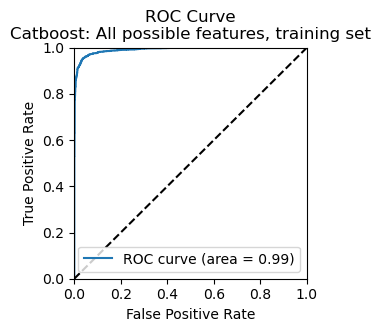

Confusion Matrix for training set:
 [[2047  286]
 [  49 2822]]
Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0   days_in_shelter    19.164922
1        intake_age    15.414941
2             breed    12.725534
3             color    11.557784
4  intake_condition     9.875424
5              size     9.260936
6    outcome_season     8.052521
7       intake_type     8.048518
8               sex     5.899420

Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.88      0.92      2333
        True       0.91      0.98      0.94      2871

    accuracy                           0.94      5204
   macro avg       0.94      0.93      0.93      5204
weighted avg       0.94      0.94      0.94      5204



In [78]:
model_name = "Catboost: All possible features, training set"
feature_list = ['sex',
                'size',
                'breed', 
                'color',
                'days_in_shelter',
                'outcome_season',
                'intake_age',
                'intake_condition',
                'intake_type'
                #, 'outcome_adopt_subtype'
                ]
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.1

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, loss_function="Logloss", depth=tree_depth)
clf.fit(pool, eval_set=(X_t, y_t), 
        verbose=False, 
        plot=False)
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))


## ROC curve - get data from catboost, plot with plt
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
# print("Area under the ROC curve : %f" % roc_auc)
# print(fpr)
# print(tpr)
# print(thresholds)
plt.figure(figsize=(3,3))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve\n'+model_name)
plt.legend(loc="lower right")
plt.show()
# plt.savefig(roc_j)

del fpr, tpr, thresholds, roc_auc

confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix for training set:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))

# # confusion graph
# plt.figure(figsize=(4, 3))
# sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[
#             'Pred Neg', 'Pred Pos'], yticklabels=['Act Neg', 'Actual Pos'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # feature importance graph
# feat_arry = np.array(feature_list)
# importances = clf.get_feature_importance()
# sorted_indices = np.argsort(importances)[::-1] 
# plt.figure(figsize=(5, 3))
# plt.bar(range(len(feature_list)), importances[sorted_indices])
# plt.xticks(range(len(feature_list)), feat_arry[sorted_indices], rotation=90)
# plt.title("Feature Importance")
# plt.show()
# del feat_arry, importances, sorted_indices

del feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 



#### Using only one feature

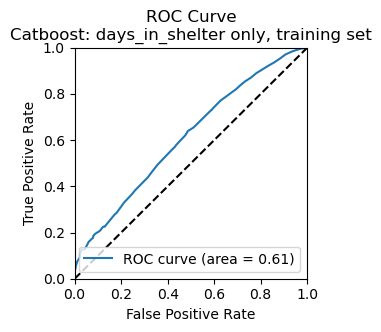

Confusion Matrix for training set:
 [[ 803 1530]
 [ 597 2274]]
Used dataset leave statistics for fstr calculation
        Feature Id  Importances
0  days_in_shelter        100.0

Classification Report:
              precision    recall  f1-score   support

       False       0.57      0.34      0.43      2333
        True       0.60      0.79      0.68      2871

    accuracy                           0.59      5204
   macro avg       0.59      0.57      0.56      5204
weighted avg       0.59      0.59      0.57      5204



In [79]:
model_name = "Catboost: days_in_shelter only, training set"
feature_list = [#'sex',
                # 'size',
                # 'breed', 
                # 'color',
                 'days_in_shelter',
                # 'outcome_season',
                # 'intake_age',
                # 'intake_condition',
                # 'intake_type'
                #, 'outcome_adopt_subtype'
                ]
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.1

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, loss_function="Logloss", depth=tree_depth)
clf.fit(pool, eval_set=(X_t, y_t), 
        verbose=False, 
        plot=False)
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))


## ROC curve - get data from catboost, plot with plt
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
# print("Area under the ROC curve : %f" % roc_auc)
# print(fpr)
# print(tpr)
# print(thresholds)

plt.figure(figsize=(3,3))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve\n'+model_name)
plt.legend(loc="lower right")
plt.show()
# plt.savefig(roc_j)

del fpr, tpr, thresholds, roc_auc


confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix for training set:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))

# # confusion graph
# plt.figure(figsize=(4, 3))
# sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[
#             'Pred Neg', 'Pred Pos'], yticklabels=['Act Neg', 'Actual Pos'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # feature importance graph
# feat_arry = np.array(feature_list)
# importances = clf.get_feature_importance()
# sorted_indices = np.argsort(importances)[::-1] 
# plt.figure(figsize=(5, 3))
# plt.bar(range(len(feature_list)), importances[sorted_indices])
# plt.xticks(range(len(feature_list)), feat_arry[sorted_indices], rotation=90)
# plt.title("Feature Importance")
# plt.show()
# del feat_arry, importances, sorted_indices


del feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 



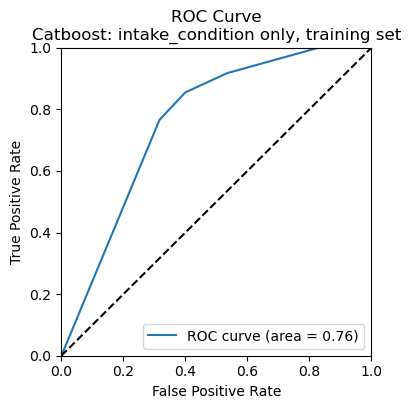

Model params:
{'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'Logloss'}
Confusion Matrix:
 [[1401  932]
 [ 417 2454]]
Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0  intake_condition        100.0

Classification Report:
              precision    recall  f1-score   support

       False       0.77      0.60      0.68      2333
        True       0.72      0.85      0.78      2871

    accuracy                           0.74      5204
   macro avg       0.75      0.73      0.73      5204
weighted avg       0.75      0.74      0.74      5204



In [80]:

model_name = "Catboost: intake_condition only, training set"
feature_list = [#'sex',
                # 'size',
                # 'breed', 
                # 'color',
                # 'days_in_shelter',
                # 'outcome_season',
                # 'intake_age',
                'intake_condition',
                # 'intake_type'
                #, 'outcome_adopt_subtype'
                ]
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.1

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, 
                          loss_function="Logloss", depth=tree_depth)
clf.fit(pool, eval_set=(X_t, y_t), 
        verbose=False, 
        # plot=True
        )
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))

## ROC curve - get data from catboost, plot with plt
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
# print("Area under the ROC curve : %f" % roc_auc)
# print(fpr)
# print(tpr)
# print(thresholds)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve\n'+model_name)
plt.legend(loc="lower right")
plt.show()
# plt.savefig(roc_j)

del fpr, tpr, thresholds, roc_auc


print('Model params:')
print(clf.get_params())

confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))

# # confusion graph
# plt.figure(figsize=(4, 3))
# sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[
#             'Pred Neg', 'Pred Pos'], yticklabels=['Act Neg', 'Actual Pos'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # importance graph
# feat_arry = np.array(feature_list)
# importances = clf.get_feature_importance()
# sorted_indices = np.argsort(importances)[::-1] 
# plt.figure(figsize=(5, 3))
# plt.bar(range(len(feature_list)), importances[sorted_indices])
# plt.xticks(range(len(feature_list)), feat_arry[sorted_indices], rotation=90)
# plt.title("Feature Importance")
# plt.show()
# del feat_arry, importances, sorted_indices


del model_name, feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 



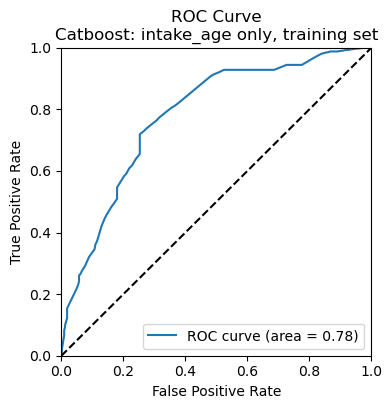

Model params:
{'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'Logloss'}
Confusion Matrix:
 [[1211 1122]
 [ 267 2604]]
Used dataset leave statistics for fstr calculation
   Feature Id  Importances
0  intake_age        100.0

Classification Report:
              precision    recall  f1-score   support

       False       0.82      0.52      0.64      2333
        True       0.70      0.91      0.79      2871

    accuracy                           0.73      5204
   macro avg       0.76      0.71      0.71      5204
weighted avg       0.75      0.73      0.72      5204



In [81]:

model_name = "Catboost: intake_age only, training set"
feature_list = [#'sex',
                # 'size',
                # 'breed', 
                # 'color',
                # 'days_in_shelter',
                # 'outcome_season',
                'intake_age',
                # 'intake_condition',
                # 'intake_type'
                #, 'outcome_adopt_subtype'
                ]
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.1

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, 
                          loss_function="Logloss", depth=tree_depth)
clf.fit(pool, eval_set=(X_t, y_t), 
        verbose=False, 
        # plot=True
        )
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))

## ROC curve - get data from catboost, plot with plt
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
# print("Area under the ROC curve : %f" % roc_auc)
# print(fpr)
# print(tpr)
# print(thresholds)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve\n'+model_name)
plt.legend(loc="lower right")
plt.show()
# plt.savefig(roc_j)

del fpr, tpr, thresholds, roc_auc


print('Model params:')
print(clf.get_params())

confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))

# # confusion graph
# plt.figure(figsize=(4, 3))
# sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[
#             'Pred Neg', 'Pred Pos'], yticklabels=['Act Neg', 'Actual Pos'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # importance graph
# feat_arry = np.array(feature_list)
# importances = clf.get_feature_importance()
# sorted_indices = np.argsort(importances)[::-1] 
# plt.figure(figsize=(5, 3))
# plt.bar(range(len(feature_list)), importances[sorted_indices])
# plt.xticks(range(len(feature_list)), feat_arry[sorted_indices], rotation=90)
# plt.title("Feature Importance")
# plt.show()
# del feat_arry, importances, sorted_indices


del model_name, feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 



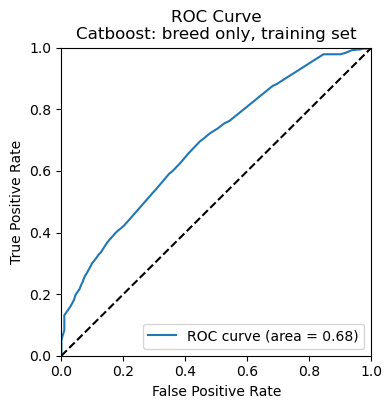

Model params:
{'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'Logloss'}
Confusion Matrix:
 [[ 741 1592]
 [ 354 2517]]
Used dataset leave statistics for fstr calculation
  Feature Id  Importances
0      breed        100.0

Classification Report:
              precision    recall  f1-score   support

       False       0.68      0.32      0.43      2333
        True       0.61      0.88      0.72      2871

    accuracy                           0.63      5204
   macro avg       0.64      0.60      0.58      5204
weighted avg       0.64      0.63      0.59      5204



In [85]:

feat = "breed"
model_name = "Catboost: "+ feat+" only, training set"
feature_list = [ feat, #'sex',
                # 'size',
                # 'breed', 
                # 'color',
                # 'days_in_shelter',
                # 'outcome_season',
                # 'intake_age',
                # 'intake_condition',
                # 'intake_type'
                #, 'outcome_adopt_subtype'
                ]
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.1

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, 
                          loss_function="Logloss", depth=tree_depth)
clf.fit(pool, eval_set=(X_t, y_t), 
        verbose=False, 
        # plot=True
        )
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))

## ROC curve - get data from catboost, plot with plt
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
# print("Area under the ROC curve : %f" % roc_auc)
# print(fpr)
# print(tpr)
# print(thresholds)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve\n'+model_name)
plt.legend(loc="lower right")
plt.show()
# plt.savefig(roc_j)

del fpr, tpr, thresholds, roc_auc


print('Model params:')
print(clf.get_params())

confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))

# # confusion graph
# plt.figure(figsize=(4, 3))
# sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[
#             'Pred Neg', 'Pred Pos'], yticklabels=['Act Neg', 'Actual Pos'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # importance graph
# feat_arry = np.array(feature_list)
# importances = clf.get_feature_importance()
# sorted_indices = np.argsort(importances)[::-1] 
# plt.figure(figsize=(5, 3))
# plt.bar(range(len(feature_list)), importances[sorted_indices])
# plt.xticks(range(len(feature_list)), feat_arry[sorted_indices], rotation=90)
# plt.title("Feature Importance")
# plt.show()
# del feat_arry, importances, sorted_indices


del feat, model_name, feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 



### kfold cross validation

In [22]:
# use built in cv function

feature_list = ['sex',
                'size',
                'breed', 
                'color',
                'days_in_shelter',
                'outcome_season',
                'intake_age',
                'intake_condition',
                'intake_type'
                # 'outcome_adopt_subtype'
                ]
X_t = X_train[feature_list]
X_t = X_t.astype(str)
pool = Pool(X_t, y_train, cat_features=feature_list, feature_names=feature_list)


# cv_dataset = pool
#Pool(data=cv_data,label=labels,cat_features=cat_features)

params = {"iterations": 1000,
          "depth": 6,
          "loss_function": "Logloss",
          "verbose": False,
          "roc_file": "roc-file"}

scores = cv(pool,
            params,
            fold_count=9,
            partition_random_seed=1342,
            plot="True"
            )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/9]

bestTest = 0.4532106961
bestIteration = 698

Training on fold [1/9]

bestTest = 0.451290796
bestIteration = 628

Training on fold [2/9]

bestTest = 0.521813224
bestIteration = 927

Training on fold [3/9]

bestTest = 0.4523192002
bestIteration = 742

Training on fold [4/9]

bestTest = 0.4802271378
bestIteration = 888

Training on fold [5/9]

bestTest = 0.4938899392
bestIteration = 829

Training on fold [6/9]

bestTest = 0.4636517774
bestIteration = 357

Training on fold [7/9]

bestTest = 0.4757854792
bestIteration = 549

Training on fold [8/9]

bestTest = 0.4526954213
bestIteration = 768



In [23]:
# use built in cv function

feature_list = ['sex',
                'size',
                'breed', 
                'color',
                'days_in_shelter',
                'outcome_season',
                'intake_age',
                'intake_condition',
                'intake_type'
                # 'outcome_adopt_subtype'
                ]
X_t = X_train[feature_list]
X_t = X_t.astype(str)
pool = Pool(X_t, y_train, cat_features=feature_list, feature_names=feature_list)


params = {"iterations": 500,
          "depth": 6,
          "loss_function": "Logloss",
          "verbose": False,
          "roc_file": "roc-file"}

scores = cv(pool,
            params,
            fold_count=9,
            partition_random_seed=1342,
            plot="True"
            )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/9]

bestTest = 0.4539212699
bestIteration = 490

Training on fold [1/9]

bestTest = 0.4521204116
bestIteration = 478

Training on fold [2/9]

bestTest = 0.5239254373
bestIteration = 493

Training on fold [3/9]

bestTest = 0.4537215257
bestIteration = 491

Training on fold [4/9]

bestTest = 0.4822743572
bestIteration = 496

Training on fold [5/9]

bestTest = 0.4989749038
bestIteration = 499

Training on fold [6/9]

bestTest = 0.4636517774
bestIteration = 357

Training on fold [7/9]

bestTest = 0.4765567725
bestIteration = 495

Training on fold [8/9]

bestTest = 0.454350654
bestIteration = 499



In [26]:
mdl_title = "all features"
feature_list = ['sex',
                'size',
                'breed', 
                'color',
                'days_in_shelter',
                'outcome_season',
                'intake_age',
                'intake_condition',
                'intake_type',
                # 'outcome_adopt_subtype'
                ]
tree_depth = 6
cv_splits  = 9

kfold  = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1342)
scores = pd.DataFrame(columns=['accuracy','tree_count'], index=range(cv_splits))

print(mdl_title)
i = 0
for t_idx, h_idx in kfold.split(X_train, X_train.outcome_adopt):
    X_t = dog_df[feature_list].iloc[t_idx]
    X_t = X_t.astype(str)
    y_t = dog_df.outcome_adopt.iloc[t_idx]
    X_h = dog_df[feature_list].iloc[h_idx]
    X_h = X_h.astype(str)
    y_h = dog_df.outcome_adopt.iloc[h_idx]

    pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)

    clf  = CatBoostClassifier(iterations=1000, learning_rate=0.1, loss_function="Logloss", depth=tree_depth, task_type="CPU").fit(pool, eval_set=(X_h, y_h), verbose=False)
    scores.loc[i, "tree_count"] = clf.tree_count_
    scores.loc[i, "accuracy"]   = accuracy_score(y_true = y_h, y_pred = clf.predict(X_h))
    print()
    print(confusion_matrix(y_true = y_h, y_pred = clf.predict(X_h)))
    print()
    print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
    print(classification_report(y_true = y_h, y_pred = clf.predict(X_h)))
    print()
    del clf, pool   
    del X_t, y_t, X_h, y_h
    i+=1
    print(i+1,'-'*50)

del kfold, scores

all features

[[152  93]
 [ 38 296]]

Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0  intake_condition    22.388166
1        intake_age    17.151920
2   days_in_shelter    14.076996
3             color     9.756916
4             breed     9.689944
5              size     8.240592
6               sex     6.673577
7       intake_type     6.376681
8    outcome_season     5.645208
              precision    recall  f1-score   support

       False       0.80      0.62      0.70       245
        True       0.76      0.89      0.82       334

    accuracy                           0.77       579
   macro avg       0.78      0.75      0.76       579
weighted avg       0.78      0.77      0.77       579


2 --------------------------------------------------

[[151  96]
 [ 41 291]]

Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0  intake_condition    25.147463
1        intake_age    17.468777
2       intake_type    13

In [28]:
mdl_title = "only intake_condition"
feature_list = [#'sex',
#                 'size',
#                 'breed', 
#                 'color',
#                 'days_in_shelter',
#                 'outcome_season',
#                 'intake_age',
                'intake_condition',
                # 'intake_type',
                # 'outcome_adopt_subtype'
                ]
tree_depth = 6
cv_splits  = 9

kfold  = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1342)
scores = pd.DataFrame(columns=['accuracy','tree_count'], index=range(cv_splits))

print(mdl_title)
i = 0
for t_idx, h_idx in kfold.split(X_train, X_train.outcome_adopt):
    X_t = dog_df[feature_list].iloc[t_idx]
    X_t = X_t.astype(str)
    y_t = dog_df.outcome_adopt.iloc[t_idx]
    X_h = dog_df[feature_list].iloc[h_idx]
    X_h = X_h.astype(str)
    y_h = dog_df.outcome_adopt.iloc[h_idx]

    pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)

    clf  = CatBoostClassifier(iterations=1000, learning_rate=0.1, loss_function="Logloss", depth=tree_depth, task_type="CPU").fit(pool, eval_set=(X_h, y_h), verbose=False)
    scores.loc[i, "tree_count"] = clf.tree_count_
    scores.loc[i, "accuracy"]   = accuracy_score(y_true = y_h, y_pred = clf.predict(X_h))
    print()
    print(confusion_matrix(y_true = y_h, y_pred = clf.predict(X_h)))
    print()
    print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
    print(classification_report(y_true = y_h, y_pred = clf.predict(X_h)))
    print()
    del clf, pool   
    del X_t, y_t, X_h, y_h
    i+=1
    print(i+1,'-'*50)

del kfold, scores

only intake_condition

[[136 109]
 [ 38 296]]

Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0  intake_condition        100.0
              precision    recall  f1-score   support

       False       0.78      0.56      0.65       245
        True       0.73      0.89      0.80       334

    accuracy                           0.75       579
   macro avg       0.76      0.72      0.73       579
weighted avg       0.75      0.75      0.74       579


2 --------------------------------------------------

[[143 104]
 [ 42 290]]

Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0  intake_condition        100.0
              precision    recall  f1-score   support

       False       0.77      0.58      0.66       247
        True       0.74      0.87      0.80       332

    accuracy                           0.75       579
   macro avg       0.75      0.73      0.73       579
weighted avg       0.75      0.75      0.